In [2]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

import comsolmllinux.custom_ml

In [3]:
from comsolmllinux import read_data
from comsolmllinux.filter import butter_lowpass_filter
from comsolmllinux.custom_fk import tx_fk_plot, make_fk
from comsolmllinux.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results
from comsolmllinux import vel_estim

In [4]:
import importlib
import sys
importlib.reload(sys.modules['comsolmllinux.custom_ml'])
from comsolmllinux.custom_ml import plot_reg_results


In [5]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -12
encoding_dim = 64 #256? #64
dt = 1e-6
dx = 3456*0.2e-3/12

In [92]:
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'input_synth_random', 'concat_traces.mat'))

In [93]:
X = mat['concat_traces'].astype('float32')
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (1404, 73, 401))

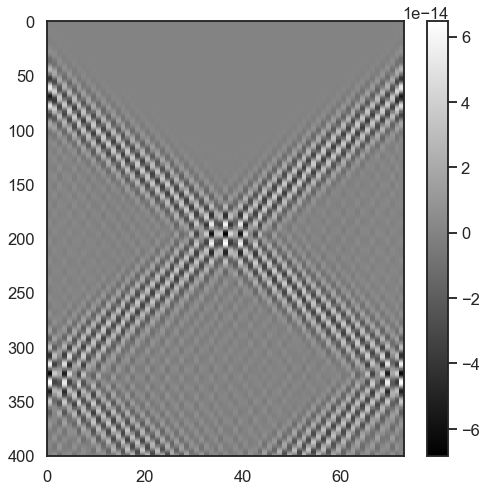

In [94]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[1,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [95]:
# This cell removes the repeated trace and rotates the dataset with half a circle
X = X[:,:72,:]
X = np.roll(X, 36,axis=1)

In [96]:
X.shape

(1404, 72, 401)

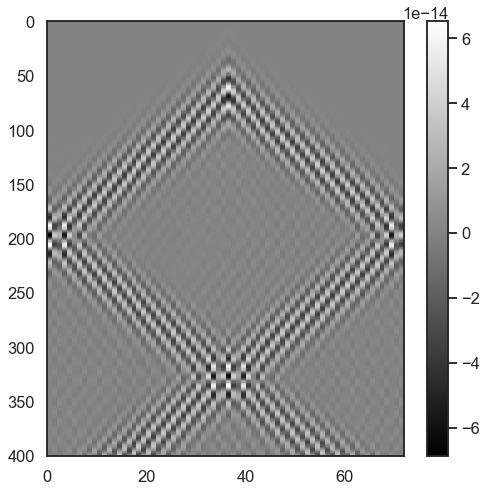

In [98]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [99]:
X = X[:,::6,:] #Selecting clock positions. Comment out if all positions

In [100]:
X.shape

(1404, 12, 401)

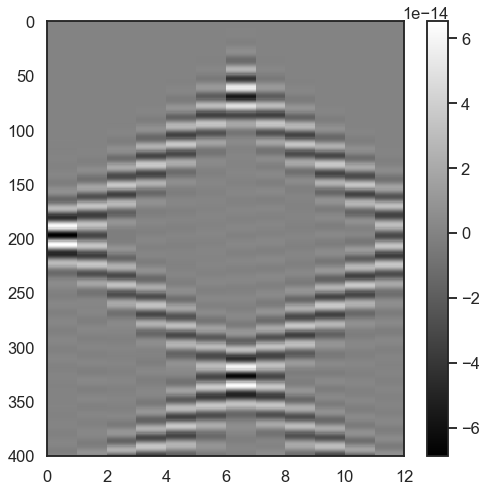

In [101]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [102]:
X.shape

(1404, 12, 401)

In [103]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

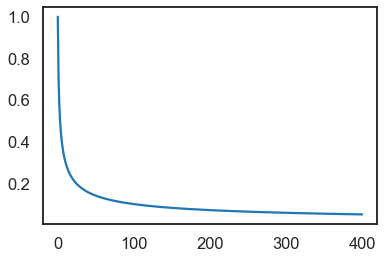

In [104]:
plt.plot(1/(time_scaling[0]))
plt.show()

In [105]:
X = np.divide(X, time_scaling)

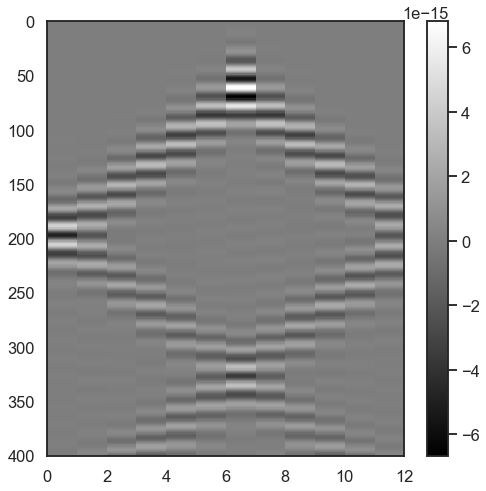

In [106]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [107]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'input_synth_random', 'labels.csv'))

In [108]:
labels

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var,model_rough_coeff,num_pits
0,model_c3456_t030_d000_p013_r720_s411805890,6.0,411805890,0.0,2.6,408.730917,42.345498,6.0,5.2,5.883391,6.0,0.160613,0.025796,1.210837,0
1,model_c3456_t030_d001_p005_r800_s406998315,6.0,406998315,0.2,1.0,450.953609,10.194209,6.0,5.0,5.920139,6.0,0.139503,0.019461,1.163191,2
2,model_c3456_t030_d001_p005_r858_s422169219,6.0,422169219,0.2,1.0,479.033110,82.661567,6.0,5.2,5.901562,6.0,0.133777,0.017896,1.115969,0
3,model_c3456_t030_d001_p006_r263_s244758783,6.0,244758783,0.2,1.2,318.421174,24.588559,6.0,4.6,5.390104,5.4,0.197775,0.039115,1.319480,10
4,model_c3456_t030_d001_p015_r791_s244868190,6.0,244868190,0.2,3.0,456.027434,79.127784,6.0,3.0,5.860648,6.0,0.218671,0.047817,1.168225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,model_c3456_t050_d020_p011_r482_s417725147,10.0,417725147,4.0,2.2,494.474170,36.159063,10.0,3.8,9.088889,9.6,1.174004,1.378285,1.318639,10
1400,model_c3456_t050_d020_p011_r945_s363925502,10.0,363925502,4.0,2.2,399.922248,73.197173,10.0,5.2,8.908507,9.8,1.386325,1.921896,1.058199,3
1401,model_c3456_t050_d022_p003_r649_s414633366,10.0,414633366,4.4,0.6,286.816995,29.853849,10.0,4.8,9.352431,9.8,1.136713,1.292116,1.255957,9
1402,model_c3456_t050_d022_p005_r623_s240241421,10.0,240241421,4.4,1.0,237.143657,51.498730,10.0,4.8,8.968981,9.6,1.403963,1.971113,1.274175,5


In [109]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std',
                       'model_rough_coeff':'Roughness',
                       'num_pits':'Number of pits'}, inplace=True)

In [110]:
labels

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,Roughness,Number of pits
0,model_c3456_t030_d000_p013_r720_s411805890,6.0,411805890,0.0,2.6,408.730917,42.345498,6.0,5.2,5.883391,6.0,0.160613,0.025796,1.210837,0
1,model_c3456_t030_d001_p005_r800_s406998315,6.0,406998315,0.2,1.0,450.953609,10.194209,6.0,5.0,5.920139,6.0,0.139503,0.019461,1.163191,2
2,model_c3456_t030_d001_p005_r858_s422169219,6.0,422169219,0.2,1.0,479.033110,82.661567,6.0,5.2,5.901562,6.0,0.133777,0.017896,1.115969,0
3,model_c3456_t030_d001_p006_r263_s244758783,6.0,244758783,0.2,1.2,318.421174,24.588559,6.0,4.6,5.390104,5.4,0.197775,0.039115,1.319480,10
4,model_c3456_t030_d001_p015_r791_s244868190,6.0,244868190,0.2,3.0,456.027434,79.127784,6.0,3.0,5.860648,6.0,0.218671,0.047817,1.168225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,model_c3456_t050_d020_p011_r482_s417725147,10.0,417725147,4.0,2.2,494.474170,36.159063,10.0,3.8,9.088889,9.6,1.174004,1.378285,1.318639,10
1400,model_c3456_t050_d020_p011_r945_s363925502,10.0,363925502,4.0,2.2,399.922248,73.197173,10.0,5.2,8.908507,9.8,1.386325,1.921896,1.058199,3
1401,model_c3456_t050_d022_p003_r649_s414633366,10.0,414633366,4.4,0.6,286.816995,29.853849,10.0,4.8,9.352431,9.8,1.136713,1.292116,1.255957,9
1402,model_c3456_t050_d022_p005_r623_s240241421,10.0,240241421,4.4,1.0,237.143657,51.498730,10.0,4.8,8.968981,9.6,1.403963,1.971113,1.274175,5


In [111]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [112]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
#X_sample_n = make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

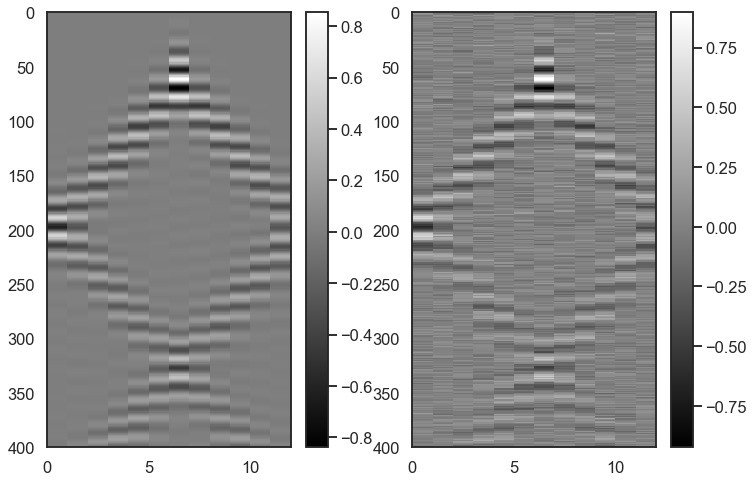

In [113]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [114]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [115]:
#X_sample_n = pick_sensors(X_sample_n, sensorindex) #Comment out if all sensors
#X_sample_c = pick_sensors(X_sample_c, sensorindex) #Comment out if all sensors
X_sample_n.shape, X_sample_c.shape

((1404, 1, 12, 400), (1404, 1, 12, 400))

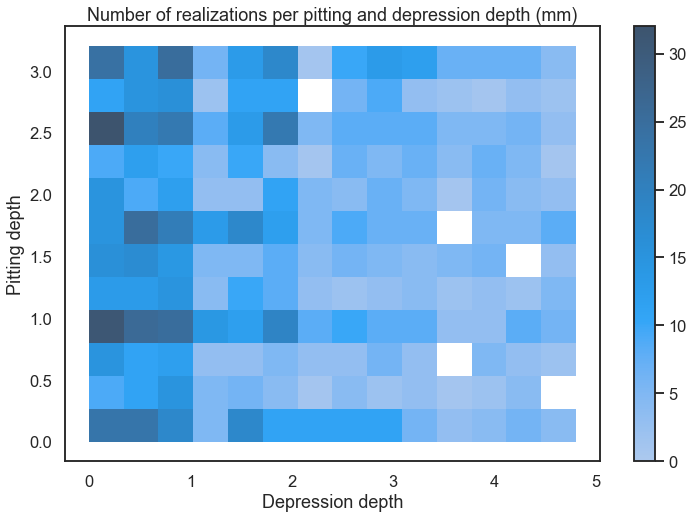

In [116]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

In [117]:
labels.columns

Index(['modelname', 'Thickness', 'seed', 'Depression depth', 'Pitting depth',
       'Depression location', 'Depression width', 'Thickness maximum',
       'Thickness minimum', 'Thickness mean', 'Thickness median',
       'Thickness std', 'thickness_var', 'Roughness', 'Number of pits'],
      dtype='object')

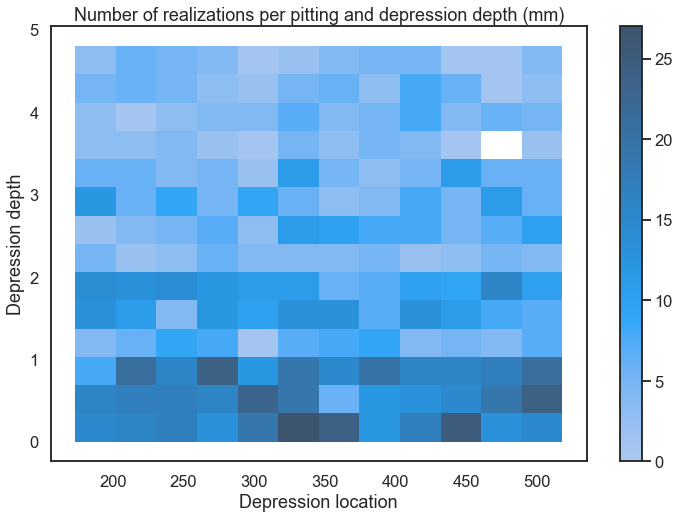

In [118]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression location", y="Depression depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

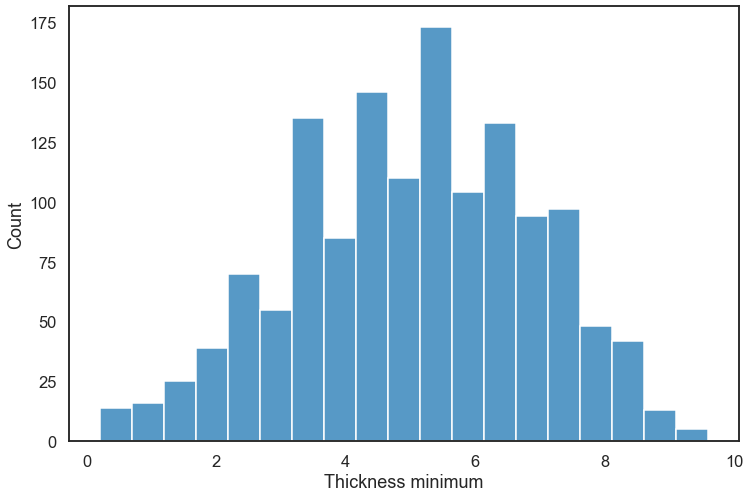

In [119]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

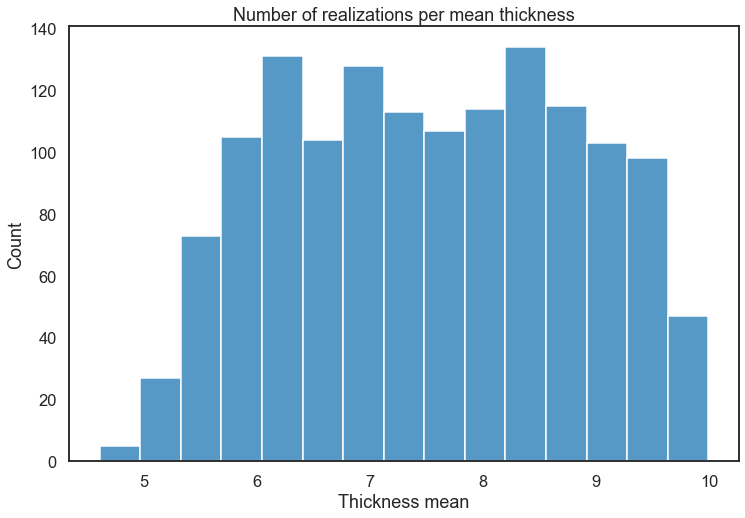

In [120]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

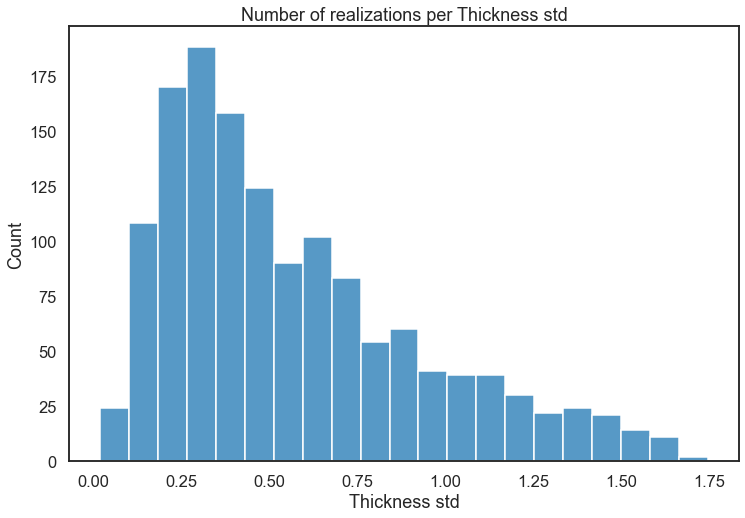

In [121]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness std")
plt.title("Number of realizations per Thickness std")
plt.show()

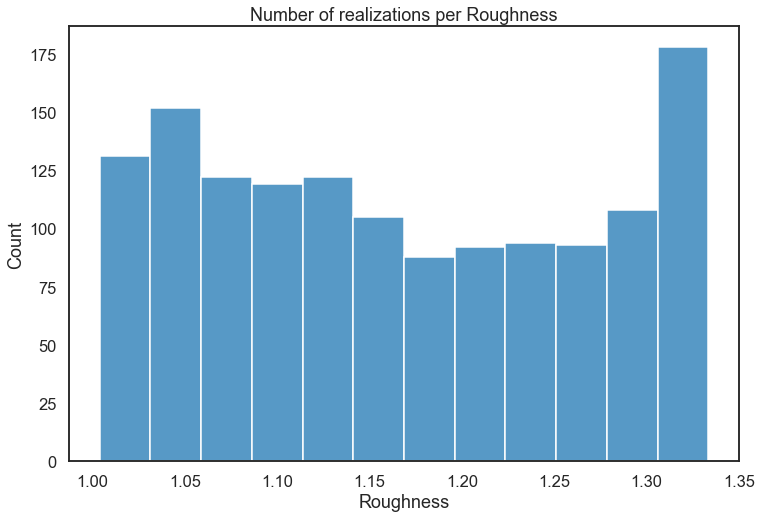

In [122]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Roughness")
plt.title("Number of realizations per Roughness")
plt.show()

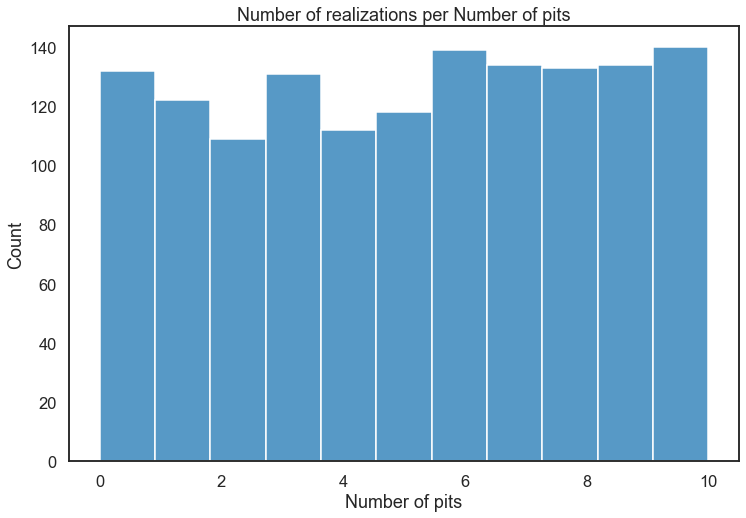

In [123]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Number of pits", bins=11)
plt.title("Number of realizations per Number of pits")
plt.show()

# ML

In [124]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [125]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

## Autoencoder

Epoch 1/100
5/5 [==============================] - 2s 130ms/step - loss: 0.0111 - val_loss: 0.0079
Epoch 2/100
5/5 [==============================] - 1s 102ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 3/100
5/5 [==============================] - 1s 107ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 4/100
5/5 [==============================] - 1s 118ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/100
5/5 [==============================] - 1s 162ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/100
5/5 [==============================] - 1s 161ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
5/5 [==============================] - 1s 189ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
5/5 [==============================] - 1s 191ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 11/

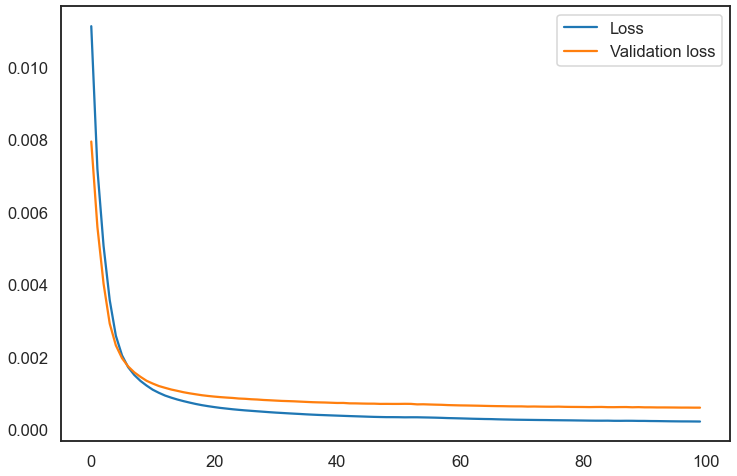

In [126]:
autoencoder_tx, encoder_tx = make_autoencoder(input_dim=x_train_flat.shape[1], encoding_dim=encoding_dim, activation='tanh')
autoencoder_tx.compile(optimizer='adam', loss='mse')

history = autoencoder_tx.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

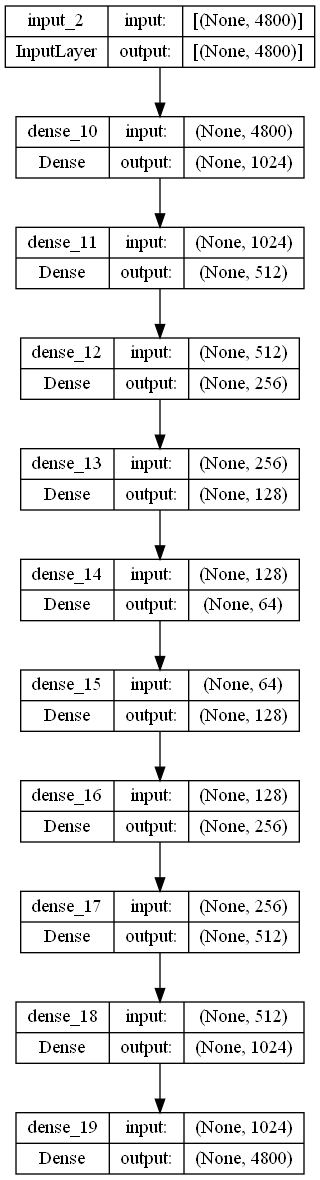

In [127]:
plot_model(autoencoder_tx, show_shapes=True, show_layer_names=True)

In [128]:
decoded_traces = autoencoder_tx.predict(x_test_flat)
encoded_traces = encoder_tx.predict(x_test_flat)

9/9 [==============================] - 0s 11ms/step


In [129]:
encoded_traces.shape, decoded_traces.shape

((281, 64), (281, 4800))

In [130]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [131]:
x_test.shape, test_decoded_shaped.shape

((281, 1, 12, 400), (281, 1, 12, 400))

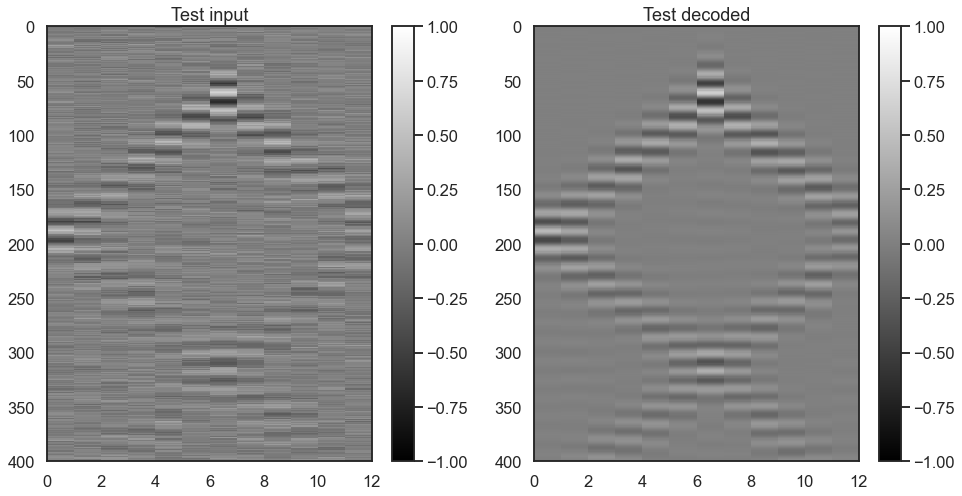

In [132]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.show()

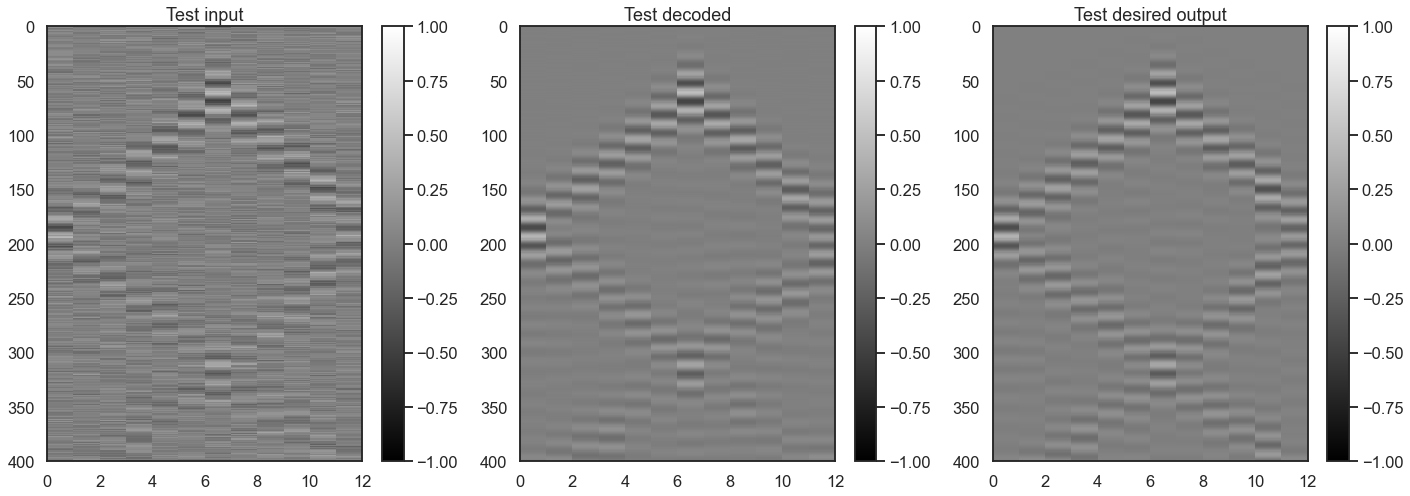

In [133]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')

plt.show()

In [134]:
autoencoder_tx.evaluate(x_test_flat, x_test_flat)

9/9 [==============================] - 0s 18ms/step - loss: 0.0045


0.0045000663958489895

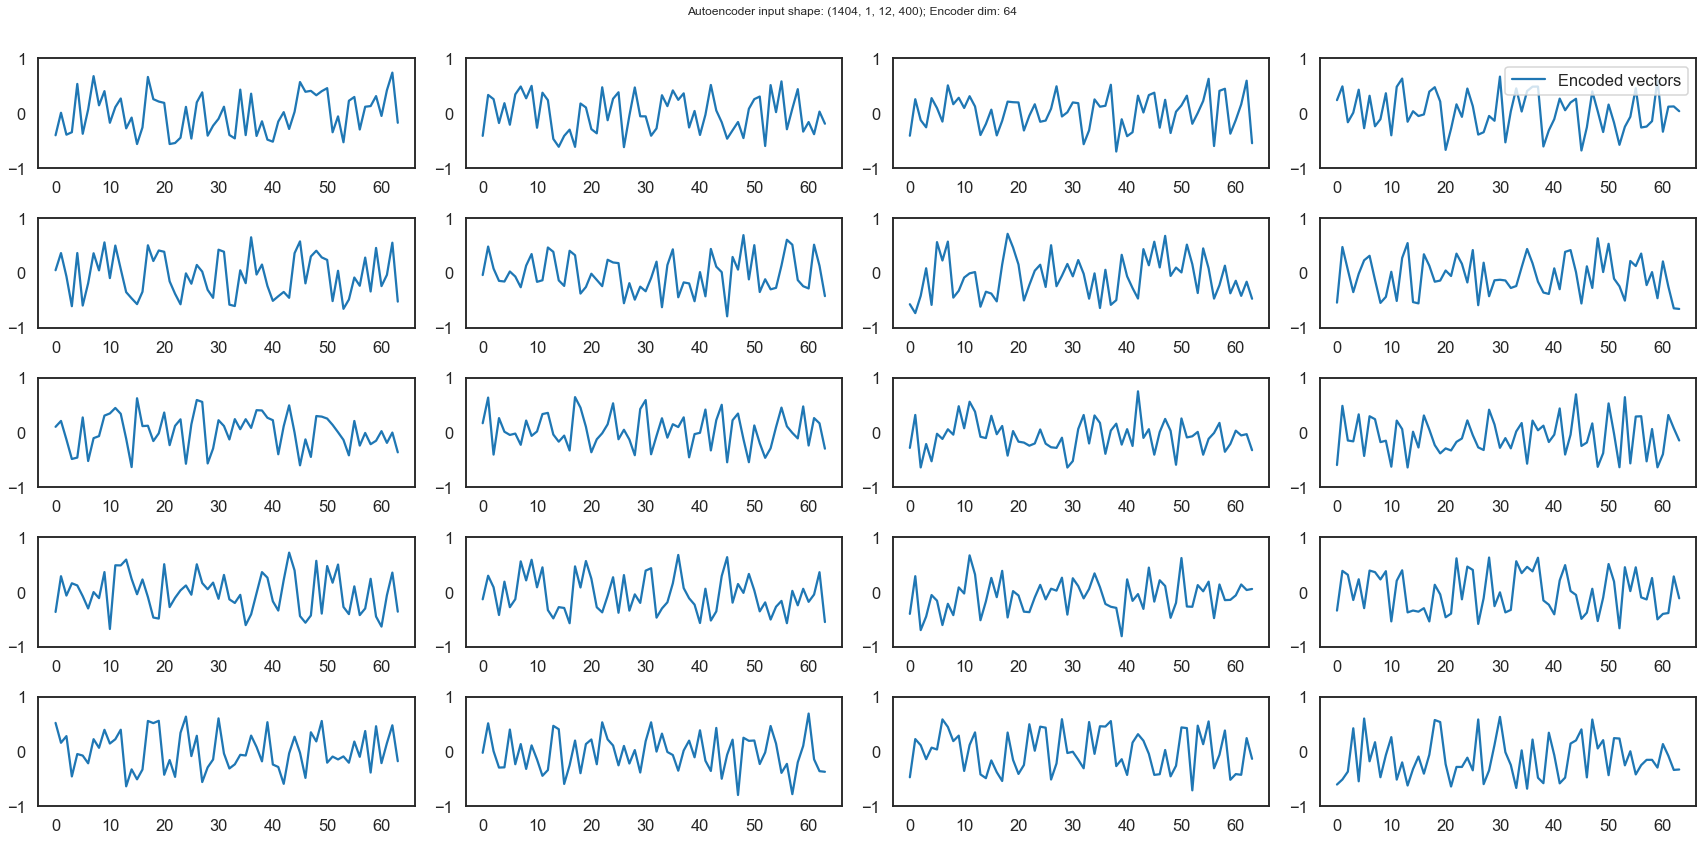

In [135]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [136]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(1404, 4800)

In [137]:
encoded_all = encoder_tx.predict(X_sample_flat)

44/44 [==============================] - 0s 6ms/step


In [138]:
labels.columns

Index(['modelname', 'Thickness', 'seed', 'Depression depth', 'Pitting depth',
       'Depression location', 'Depression width', 'Thickness maximum',
       'Thickness minimum', 'Thickness mean', 'Thickness median',
       'Thickness std', 'thickness_var', 'Roughness', 'Number of pits'],
      dtype='object')

In [139]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width', 'Depression location', 'Pitting depth', 'Roughness', 'Number of pits']

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


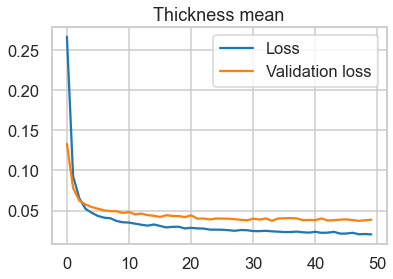

9/9 [==============================] - 0s 2ms/step - loss: 0.0385
loss: 0.03850826993584633
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


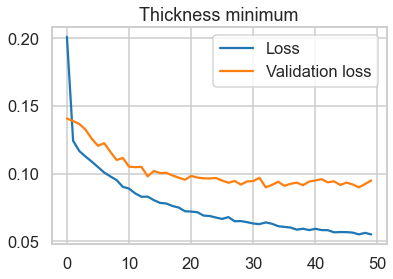

9/9 [==============================] - 0s 1ms/step - loss: 0.0950
loss: 0.09496166557073593
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


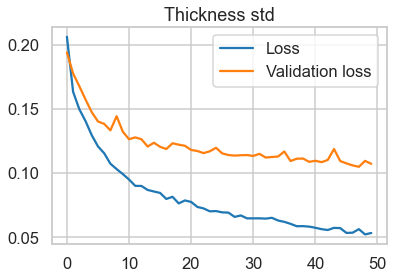

9/9 [==============================] - 0s 1ms/step - loss: 0.1072
loss: 0.10722477734088898
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


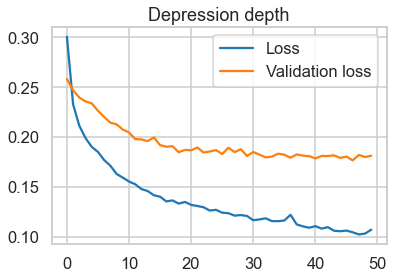

9/9 [==============================] - 0s 1ms/step - loss: 0.1813
loss: 0.1812800168991089
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


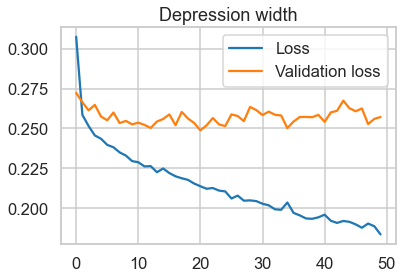

9/9 [==============================] - 0s 1ms/step - loss: 0.2572
loss: 0.2571594715118408
Depression location
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


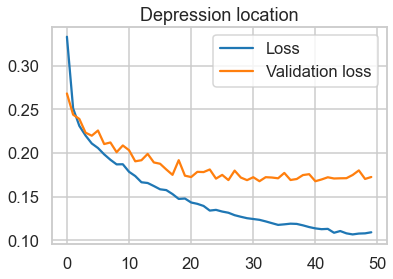

9/9 [==============================] - 0s 1ms/step - loss: 0.1726
loss: 0.1725607067346573
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


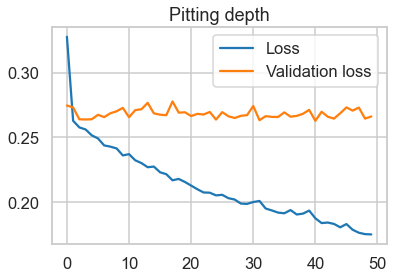

9/9 [==============================] - 0s 2ms/step - loss: 0.2662
loss: 0.2661723792552948
Roughness
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


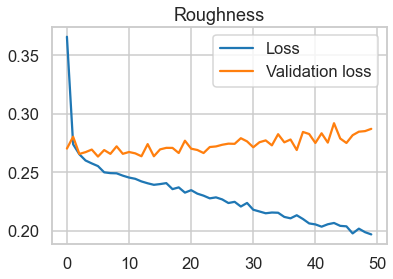

9/9 [==============================] - 0s 2ms/step - loss: 0.2871
loss: 0.2870670258998871
Number of pits
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


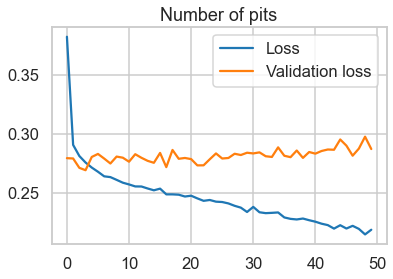

9/9 [==============================] - 0s 1ms/step - loss: 0.2872
loss: 0.2871616780757904


In [140]:
df_loss, df_test, df_predict, autoencoder_regression_models_tx, min_max_scalers = do_regression(encoded_all, label_sample, attributes)

In [141]:
'''attribute = 'Number of pits'
y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))
df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])

sns.scatterplot(sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5))
plt.show()
'''

"attribute = 'Number of pits'\ny_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))\ndf_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])\n\nsns.scatterplot(sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5))\nplt.show()\n"

In [142]:
scales = np.array([[4.5, 10], #Thickness mean
                   [-0.5, 9], #Thickness minimum
                   [0, 1.8], #Thickness std
                   [-0.5, 5.5], # Depression depth
                   [0, 100], #Depression width
                   [100, 600], #Depression location
                   [0, 4], #Pitting depth
                   [1, 1.4], #Roughness
                   [0, 10], #Number of pits
                   ])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

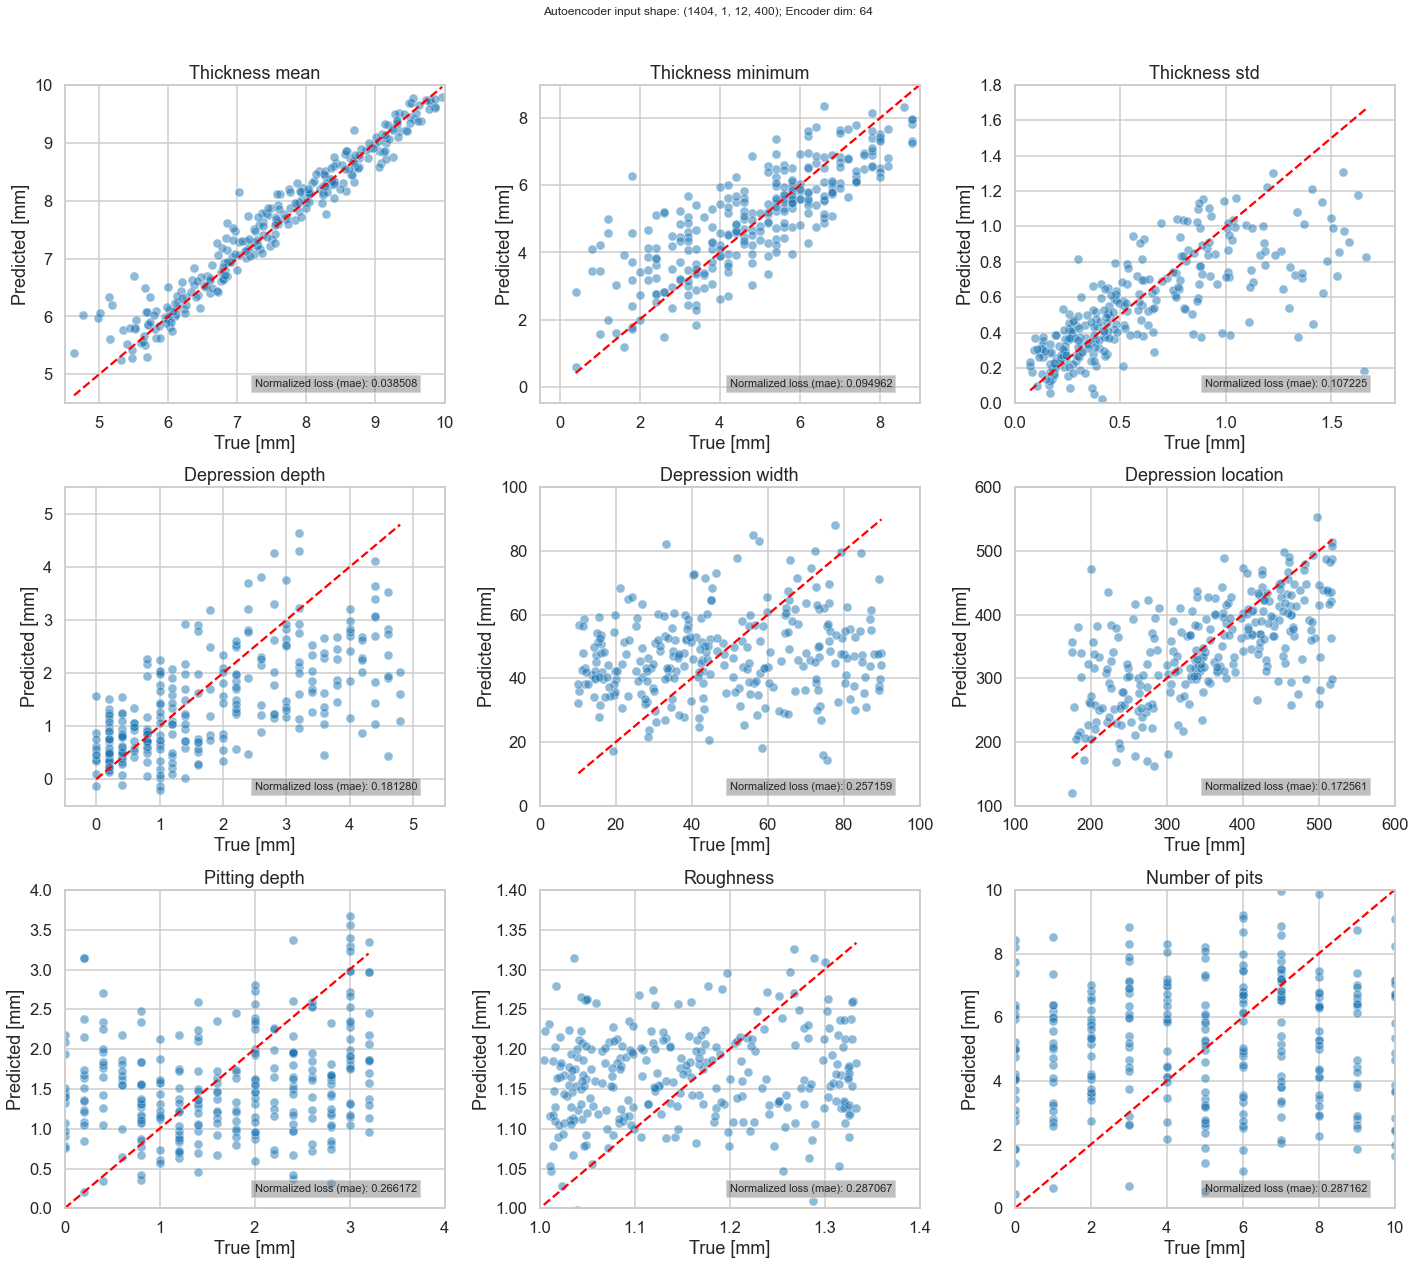

In [143]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim))

## Direct Regression

Thickness mean
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


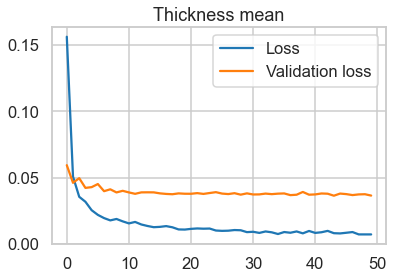

9/9 [==============================] - 0s 2ms/step - loss: 0.0366
loss: 0.036558847874403
Thickness minimum
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


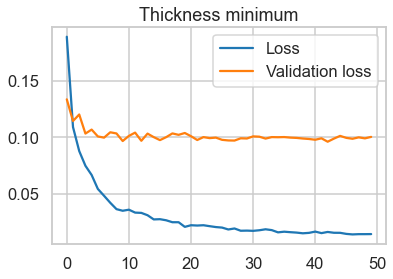

9/9 [==============================] - 0s 2ms/step - loss: 0.1003
loss: 0.1002698540687561
Thickness std
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


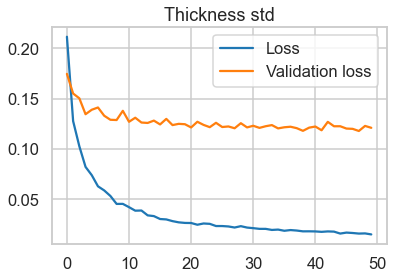

9/9 [==============================] - 0s 2ms/step - loss: 0.1210
loss: 0.12101831287145615
Depression depth
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


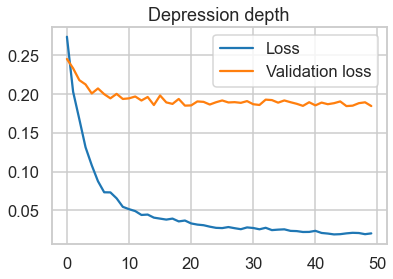

9/9 [==============================] - 0s 2ms/step - loss: 0.1847
loss: 0.18466591835021973
Depression width
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


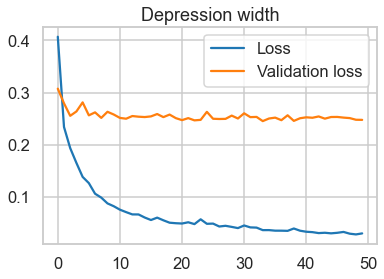

9/9 [==============================] - 0s 2ms/step - loss: 0.2479
loss: 0.24792583286762238
Depression location
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


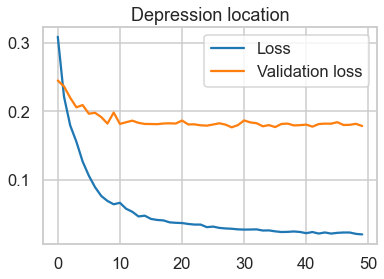

9/9 [==============================] - 0s 2ms/step - loss: 0.1788
loss: 0.17877128720283508
Pitting depth
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


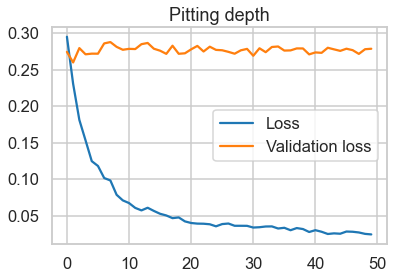

9/9 [==============================] - 0s 2ms/step - loss: 0.2785
loss: 0.278475284576416
Roughness
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


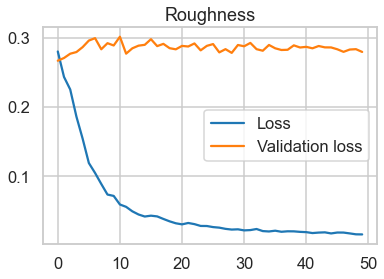

9/9 [==============================] - 0s 2ms/step - loss: 0.2797
loss: 0.2797205150127411
Number of pits
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


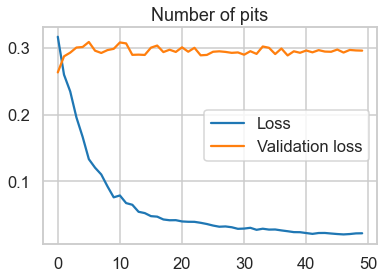

9/9 [==============================] - 0s 2ms/step - loss: 0.2961
loss: 0.2960675358772278


In [144]:
df_loss, df_test, df_predict, direct_regression_models_tx, min_max_scalers = do_regression(X_sample_n, label_sample, attributes)

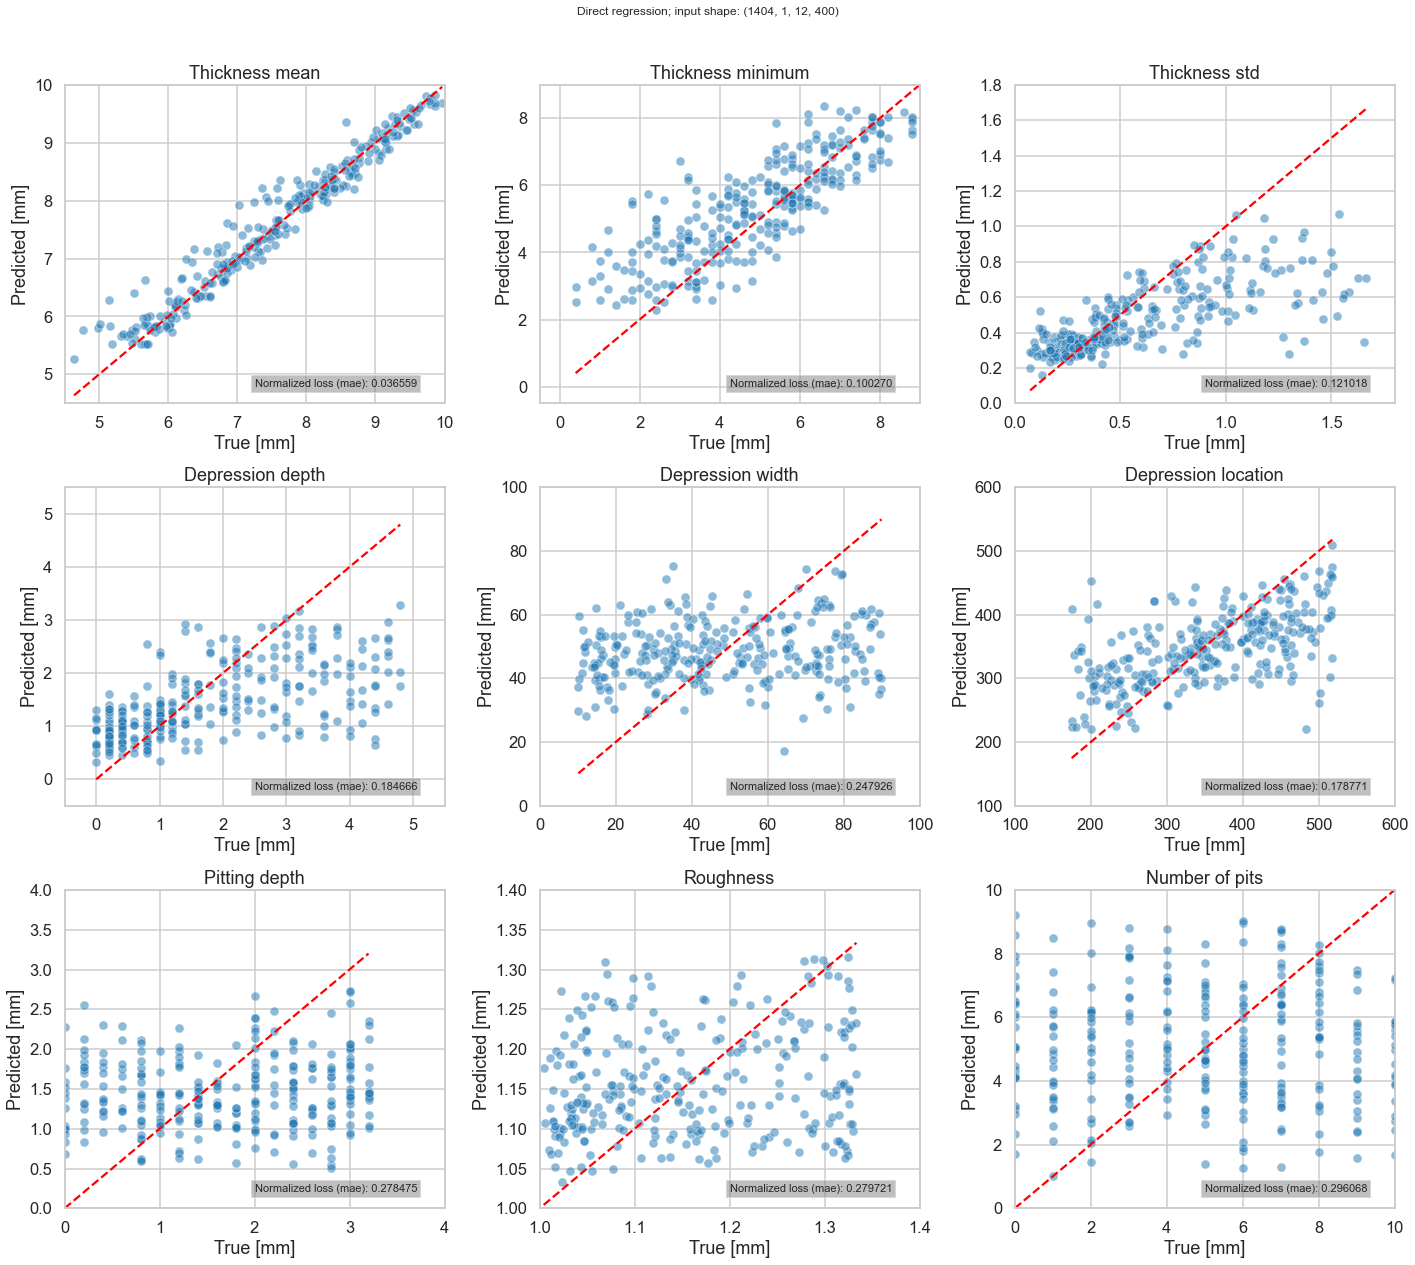

In [145]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

In [146]:
df_test[['Depression depth']]

,Depression depth
0,4.8
1,0.0
2,3.8
3,4.6
4,0.4
...,...
276,1.4
277,2.4
278,0.2
279,0.4


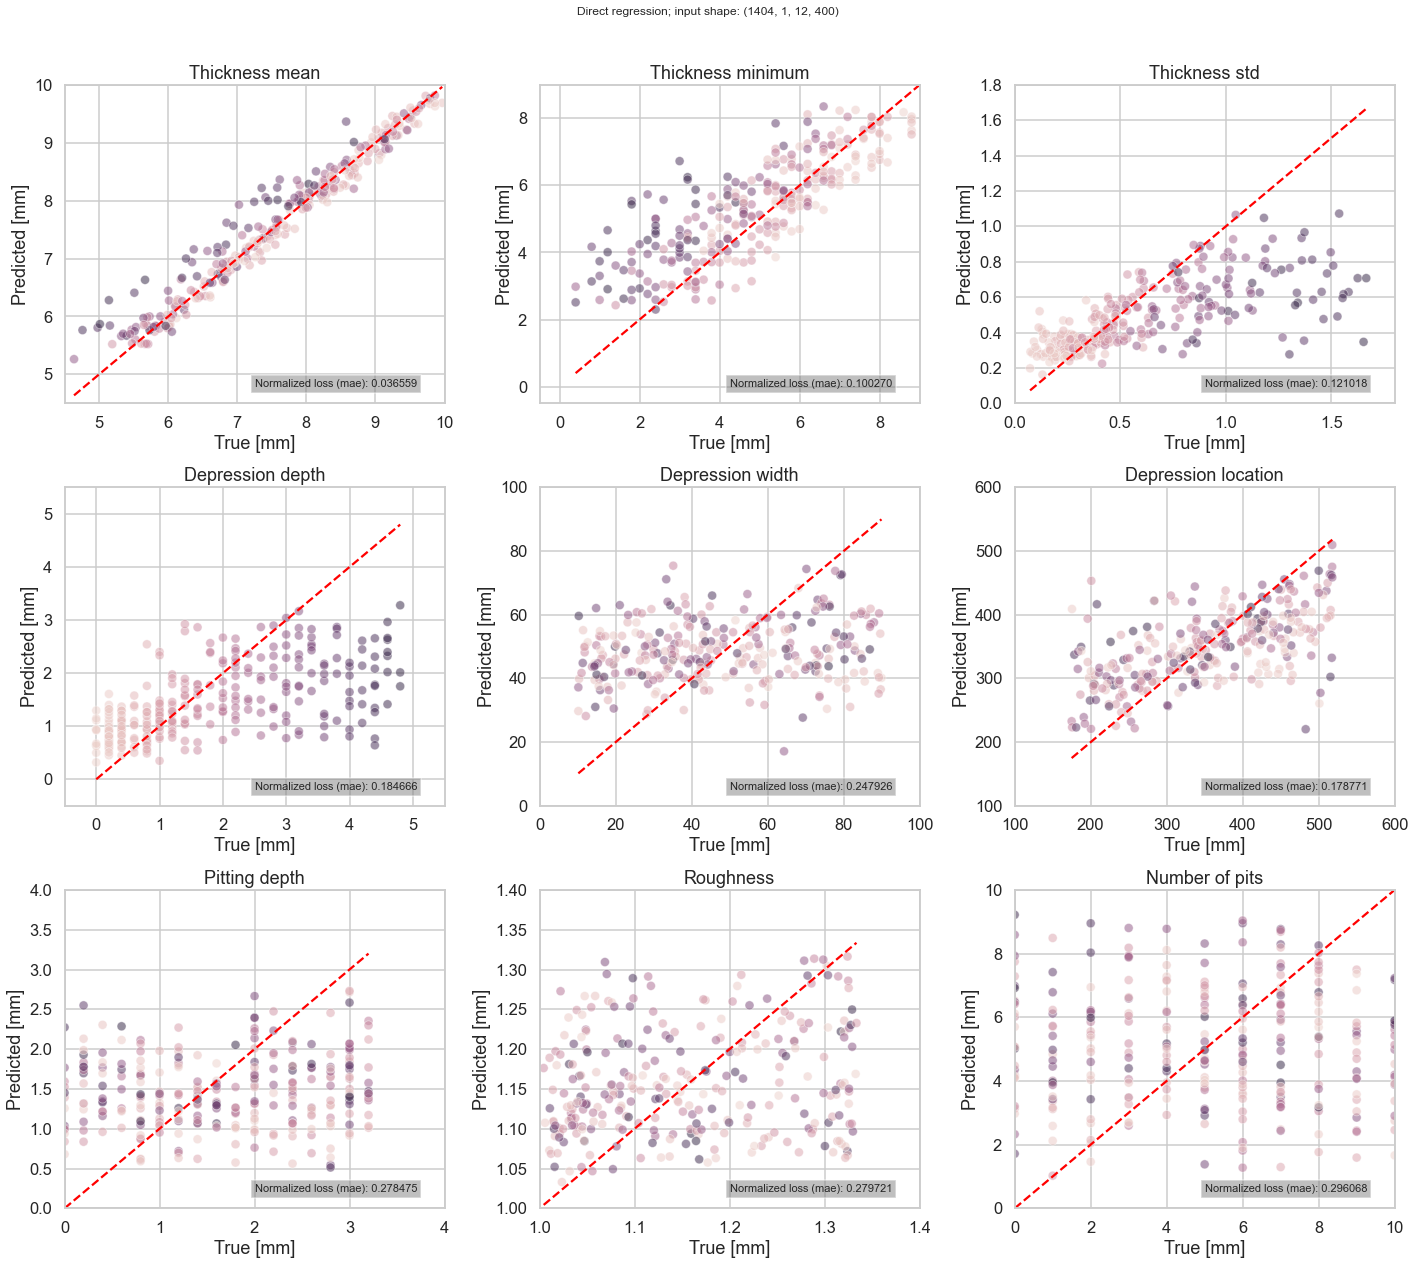

In [147]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, hue=df_test['Depression depth'], title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Estimation on Ideal Cases

In [148]:
mat_ideal = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'input_synth_ideal','concat_traces_ideal.mat'))

In [149]:
X_ideal = mat_ideal['concat_traces'].astype('float32')
X_ideal = np.swapaxes(X_ideal, 2, 1)
X_ideal.dtype, X_ideal.shape

(dtype('float32'), (21, 73, 401))

In [150]:
X_ideal = X_ideal[:,::6,:]

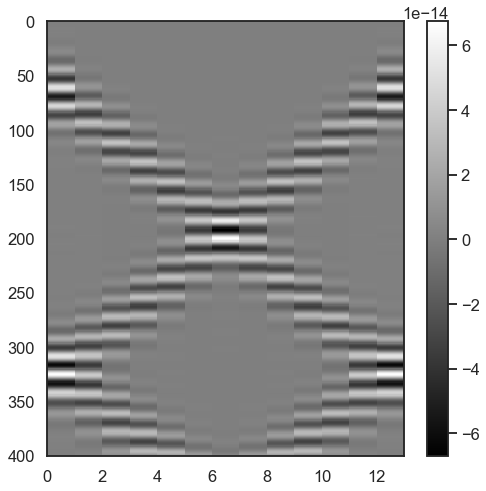

In [151]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X_ideal[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [152]:
X_ideal = np.divide(X_ideal, time_scaling)

In [153]:
labels_ideal = pd.read_csv(Path().joinpath('..', 'data', 'input_synth','input_synth_ideal', 'labels_ideal.csv'))

In [154]:
labels_ideal

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var,model_rough_coeff,num_pits
0,model_c3456_t030_d000_p000_r1000_s000,6.0,0,0,0,316.922805,67.625959,6.0,6.0,6.0,6.0,0,0,1,0
1,model_c3456_t031_d000_p000_r1000_s000,6.2,0,0,0,316.922805,67.625959,6.2,6.2,6.2,6.2,0,0,1,0
2,model_c3456_t032_d000_p000_r1000_s000,6.4,0,0,0,316.922805,67.625959,6.4,6.4,6.4,6.4,0,0,1,0
3,model_c3456_t033_d000_p000_r1000_s000,6.6,0,0,0,316.922805,67.625959,6.6,6.6,6.6,6.6,0,0,1,0
4,model_c3456_t034_d000_p000_r1000_s000,6.8,0,0,0,316.922805,67.625959,6.8,6.8,6.8,6.8,0,0,1,0
5,model_c3456_t035_d000_p000_r1000_s000,7.0,0,0,0,316.922805,67.625959,7.0,7.0,7.0,7.0,0,0,1,0
6,model_c3456_t036_d000_p000_r1000_s000,7.2,0,0,0,316.922805,67.625959,7.2,7.2,7.2,7.2,0,0,1,0
7,model_c3456_t037_d000_p000_r1000_s000,7.4,0,0,0,316.922805,67.625959,7.4,7.4,7.4,7.4,0,0,1,0
8,model_c3456_t038_d000_p000_r1000_s000,7.6,0,0,0,316.922805,67.625959,7.6,7.6,7.6,7.6,0,0,1,0
9,model_c3456_t039_d000_p000_r1000_s000,7.8,0,0,0,316.922805,67.625959,7.8,7.8,7.8,7.8,0,0,1,0


In [155]:
labels_ideal.rename(columns={'thickness':'Thickness',
                             'depression':'Depression depth',
                             'pitting':'Pitting depth',
                             'depression_mu':'Depression location',
                             'depression_sigma':'Depression width',
                             'thickness_max':'Thickness maximum',
                             'thickness_min':'Thickness minimum',
                             'thickness_mean':'Thickness mean',
                             'thickness_median':'Thickness median',
                             'thickness_std':'Thickness std',
                             'model_rough_coeff':'Roughness',
                             'num_pits':'Number of pits'}, inplace=True)

In [156]:
X_ideal_c = X_ideal[:,:,:timesamples]/X.max() # Note normalization against global max for training set. I.e. same normalization as training set
X_ideal_n = X_ideal_c + make_noise(noisedb, X_ideal_c.shape)

X_ideal_n = np.expand_dims(X_ideal_n, 1)
X_ideal_c = np.expand_dims(X_ideal_c, 1)

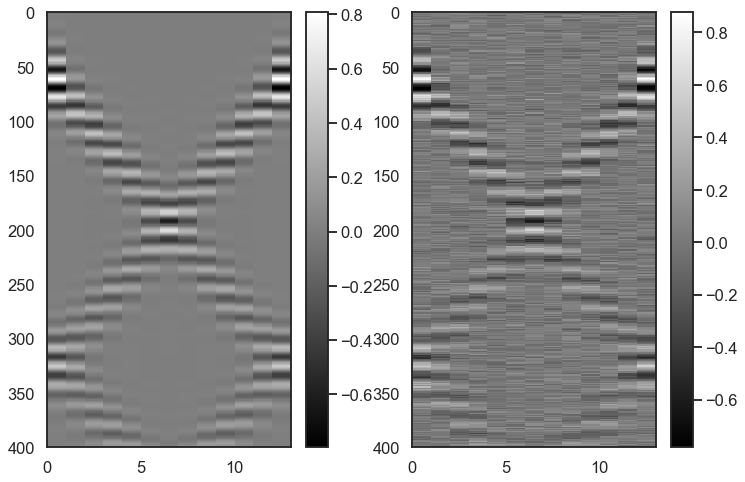

In [157]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_ideal_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_ideal_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [158]:
#X_ideal_n = pick_sensors(X_ideal_n, sensorindex) #Comment out if all sensors
#X_ideal_c = pick_sensors(X_ideal_c, sensorindex) #Comment out if all sensors
X_ideal_n.shape, X_ideal_c.shape

((21, 1, 13, 400), (21, 1, 13, 400))

In [159]:
x_ideal_flat = X_ideal_n.reshape((len(X_ideal_n), np.prod(X_ideal_n.shape[1:])))

In [160]:
decoded_traces_ideal = autoencoder_tx.predict(x_ideal_flat)

InvalidArgumentError: Graph execution error:

Detected at node 'model_2/dense_10/BiasAdd' defined at (most recent call last):
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Magnus\AppData\Local\Temp\ipykernel_5716\969202949.py", line 1, in <cell line: 1>
      decoded_traces_ideal = autoencoder_tx.predict(x_ideal_flat)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Magnus\PycharmProjects\PhD\Comsol_ML_linux\venv\lib\site-packages\keras\layers\core\dense.py", line 232, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model_2/dense_10/BiasAdd'
Matrix size-incompatible: In[0]: [21,5200], In[1]: [4800,1024]
	 [[{{node model_2/dense_10/BiasAdd}}]] [Op:__inference_predict_function_236128]

In [ ]:
decoded_traces_ideal_shaped = decoded_traces_ideal.reshape(len(decoded_traces_ideal), X_ideal_n.shape[1], X_ideal_n.shape[2], X_ideal_n.shape[3])

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(X_ideal_n[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(decoded_traces_ideal_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.show()

In [ ]:
encoded_ideal = encoder_tx.predict(x_ideal_flat)

In [ ]:
test_ideal_autoencoder_regression_estim = min_max_scalers['Thickness mean'].inverse_transform(autoencoder_regression_models_tx['Thickness mean'](encoded_ideal))#include min_max_scalers

In [ ]:
type(test_ideal_autoencoder_regression_estim)

In [ ]:
labels_ideal

## Direct regression

In [ ]:
test_ideal_direct_regression_estim = min_max_scalers['Thickness mean'].inverse_transform(direct_regression_models_tx['Thickness mean'](x_ideal_flat))[0]

In [ ]:
type(test_ideal_direct_regression_estim)

# Compare to conventional estimation method (FK); Ideal cases

In [ ]:
df_ideal_test = labels_ideal[['Thickness mean']]

In [ ]:
df_ideal_test['Autoencoder estimate'] = test_ideal_autoencoder_regression_estim
df_ideal_test['Direct regression estimate'] = test_ideal_direct_regression_estim

In [ ]:
df_ideal_test

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_ideal_test, x='Thickness mean', y='Autoencoder estimate', label='autoencoder')
sns.scatterplot(data=df_ideal_test, x='Thickness mean', y='Direct regression estimate', label='direct')
plt.minorticks_on
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', alpha=0.5)
plt.plot([5,10],[5,10], 'r--')
plt.legend()
plt.ylabel('Estimated')
plt.show()

In [ ]:
steel = vel_estim.make_lamb_curves(E=205e9, p=7850, v=0.28)

In [ ]:
ds = np.arange(5.0, 11, 0.02)

In [ ]:
decim = 6
dx = 3456*0.2e-3/72*decim

In [ ]:
X_ideal_n.shape

In [ ]:
ds_thickness = labels_ideal['Thickness mean']

df_conventional = pd.DataFrame(columns = ['True thickness', 'Estimated thickness'])
columns = list(df_conventional)
for i, thickness in enumerate(ds_thickness):
    datasetnumber = labels_ideal.index[labels_ideal['Thickness mean'] == thickness][0]
    fk_n, k_array, f_array = make_fk(X_ideal_n[datasetnumber,0,::decim, :].T, dt, dx)
    fk = 20*np.log10(np.abs(fk_n)/np.max(np.abs(fk_n)))
    thickness_estim = vel_estim.FK_thickness_estimation(fk, k_array, f_array, dx, steel.vp_antisym['A0'], ds, 25e3, 100e3, plot=False)
    #print(i, thickness_estim)
    #df.iloc[i] = [thickness, thickness_estim]
    df_temp = pd.DataFrame([[thickness, thickness_estim]], columns=columns)
    df_conventional = pd.concat([df_conventional, df_temp])
    #df.append({'True thickness':thickness, 'Estimated thickness':thickness_estim}, ignore_index=Truei


In [ ]:
X_ideal_n[0,1::decim,:].shape

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_conventinal, x='True thickness', y='Estimated thickness')
plt.plot([6, 10], [6, 10], 'r--')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', alpha=0.5)
plt.minorticks_on()
plt.show()

# Compare to conventional estimation method (FK); Non-ideal cases